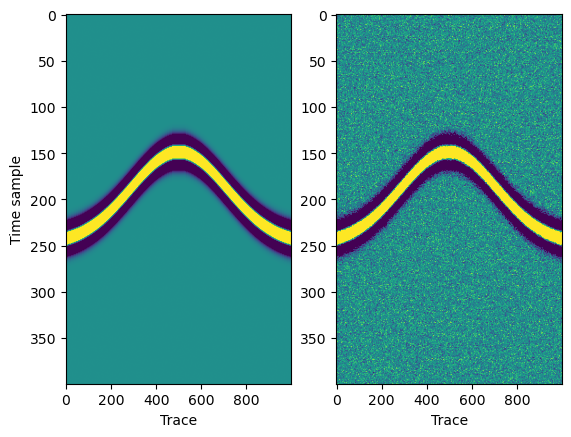

In [1]:
# Prepared On Oct 7, 2024 by Yangkang Chen, UT-Austin
#
# As a reproduced example for two papers
# [1] Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.
# [2] Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.
#
# NOTE: both examples are unsupervised learning approaches. 
# Please use the latest pyseistr package:
# https://github.com/aaspip/pyseistr
#
# Environment: 
# CPU machine
# conda create -n uml python=3.11.7
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.14.0 scikit-learn==1.2.2 seaborn==0.13.2 
# 
# GPU machine
# conda create -n uml python=3.10.14
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.11.0 scikit-learn==1.2.2 seaborn==0.13.2 
# conda install -c anaconda cudnn==8.2.1
#
#
#generate data
import numpy as np
from pyseistr import gensyn
data,noisy=gensyn(noise=True);[n1,n2]=data.shape;
import matplotlib.pyplot as plt;
plt.subplot(1,2,1);plt.imshow(data,clim=[-0.2,0.2],aspect='auto');plt.xlabel('Trace');plt.ylabel('Time sample');
plt.subplot(1,2,2);plt.imshow(noisy,clim=[-0.2,0.2],aspect='auto');plt.xlabel('Trace');
plt.show();


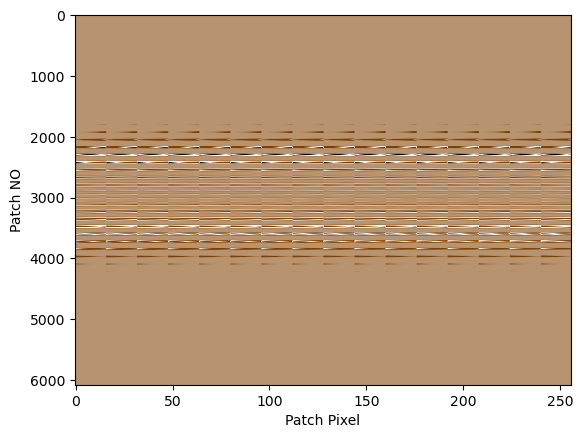

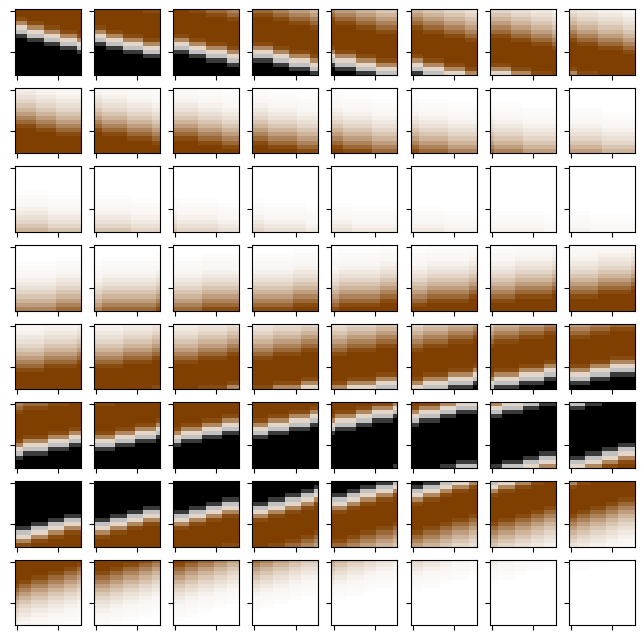

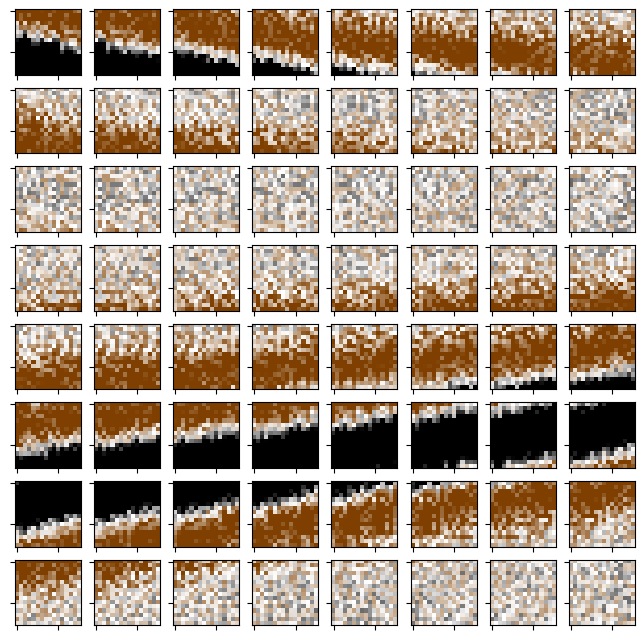

In [2]:
from pyseistr import patch2d,patch2d_inv,snr
X=patch2d(data,l1=16,l2=16,s1=8,s2=8);
Xnoisy=patch2d(noisy,l1=16,l2=16,s1=8,s2=8);

from pyseistr import cseis
plt.imshow(X,aspect='auto',cmap=cseis());plt.ylabel('Patch NO');plt.xlabel('Patch Pixel');plt.show()

# plot clean patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(X[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()


In [3]:
from keras import layers
from keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, LeakyReLU,BatchNormalization
# from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# The following architecture was used in 
# Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.

input = layers.Input(shape=(256,))                            #or from tensorflow.keras.layers import Input, Dense
x = layers.Dense(64, activation="relu", name="layer1")(input)  
x = layers.Dense(256, activation="linear", name="layer2")(x)  

# Autoencoder
autoencoder = Model(input,x)
autoencoder.summary()

# Compile
autoencoder.compile(optimizer="adam", loss='mse')


2024-10-07 15:40:43.147313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 256)            │        16,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,088 (129.25 KB)

 Trainable params: 33,088 (129.25 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)


checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)


Epoch 1/20
32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0444   
Epoch 1: val_loss improved from inf to 0.01535, saving model to best_model_2024-10-07.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0427 - val_loss: 0.0153 - learning_rate: 0.0010
Epoch 2/20
32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197 
Epoch 2: val_loss improved from 0.01535 to 0.01446, saving model to best_model_2024-10-07.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 3/20
32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 
Epoch 3: val_loss improved from 0.01446 to 0.01392, saving model to best_model_2024-10-07.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 4/20
32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 
Epoch 4: val_loss improved from 0.01392 to 0.01359, saving model to best_model_2024-10-07.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

In [5]:
Xout = autoencoder.predict(Xnoisy)

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


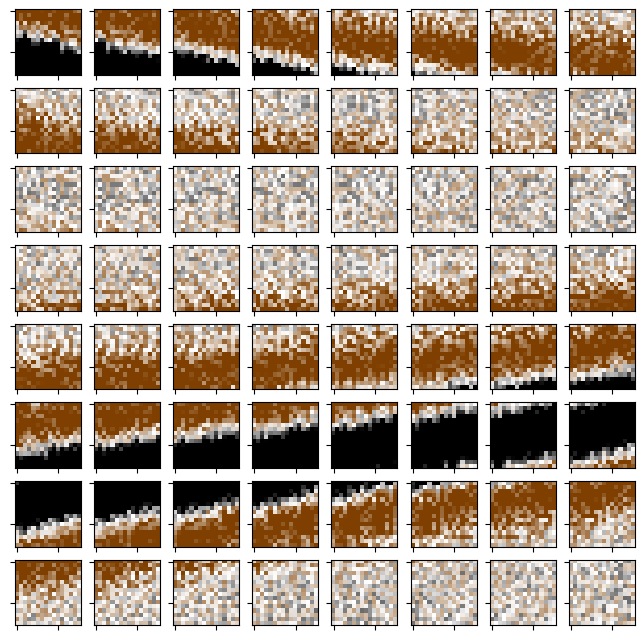

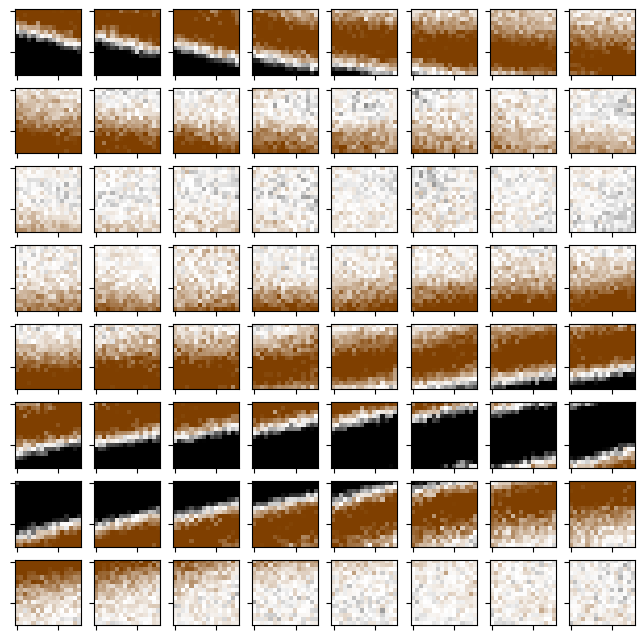

In [6]:
plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()

plt.figure(figsize=(8,8))
for ii in range(64):
            ax=plt.subplot(8,8,ii+1)
            plt.imshow(Xout[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
            plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
plt.show()


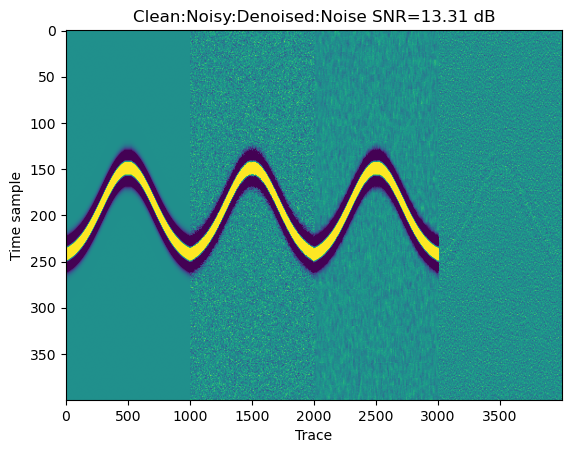

In [7]:
# reconstruct data
denoised=patch2d_inv(Xout,n1,n2,l1=16,l2=16,s1=8,s2=8);

plt.imshow(np.concatenate([data,noisy,denoised,noisy-denoised],axis=1),clim=[-0.2,0.2],aspect='auto');
plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised)))
plt.show();

In [8]:
## Different implementations

from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, LeakyReLU,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# The following architecture was used in 
# Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.

## In comparison with a simpler and textbook example
# input = layers.Input(shape=(256,))                            
# x = layers.Dense(64, activation="relu", name="layer1")(input)  
# x = layers.Dense(256, activation="linear", name="layer2")(x)  

input = Input(shape=(256,))

encoded1 = Dense(128,  activation='relu')(input)
#encoded1 = BatchNormalization()(encoded1)
#encoded1 = Dropout(0.01)(encoded1)

encoded2 = Dense(64,  activation='relu')(encoded1)
#encoded2 = BatchNormalization()(encoded2)
#encoded2 = Dropout(0.01)(encoded2)

encoded3 = Dense(32,  activation='relu' )(encoded2)
#encoded3 = BatchNormalization()(encoded3)
#encoded3 = Dropout(0.01)(encoded3)

encoded4 = Dense(16,  activation='relu' )(encoded3)
#encoded3 = BatchNormalization()(encoded3)
#encoded4 = Dropout(0.01)(encoded4)

encoded5 = Dense(8,  activation='relu' )(encoded4)
#encoded5 = BatchNormalization()(encoded5)
#encoded5 = Dropout(0.01)(encoded5)

encoded6 = Dense(4,  activation='relu' )(encoded5)
#encoded6 = BatchNormalization()(encoded6)
#encoded6 = Dropout(0.01)(encoded6)

# Decoder

decoded1aa = Dense(4,  activation='relu' )(encoded6)
#decoded1aa = BatchNormalization()(decoded1aa)
decoded1aa = concatenate([decoded1aa,encoded6])
#decoded1aa = Dropout(0.01)(decoded1aa)


decoded1a = Dense(8,  activation='relu' )(decoded1aa)
#decoded1a = BatchNormalization()(decoded1a)
decoded1a = concatenate([decoded1a,encoded5])
#decoded1a = Dropout(0.01)(decoded1a)

decoded1 = Dense(16,  activation='relu' )(decoded1a)
#decoded1 = BatchNormalization()(decoded1)
decoded1 = concatenate([decoded1,encoded4])
#decoded1 = Dropout(0.01)(decoded1)

decoded2 = Dense(32,  activation='relu')(decoded1)
#decoded2 = BatchNormalization()(decoded2)
decoded2 = concatenate([decoded2,encoded3])
#decoded2 = Dropout(0.01)(decoded2)

decoded3 = Dense(64,  activation='relu' )(decoded2)
#decoded3 = BatchNormalization()(decoded3)
decoded3 = concatenate([decoded3,encoded2])
#decoded3 = Dropout(0.01)(decoded3)

decoded4 = Dense(128,  activation='relu' )(decoded3)
#decoded4 = BatchNormalization()(decoded4)
decoded4 = concatenate([decoded4,encoded1])
#decoded4 = Dropout(0.01)(decoded4)

#decoded = Flatten()(decoded3)
x = Dense(256, activation='linear')(decoded4)


# Autoencoder
autoencoder = Model(input,x)
autoencoder.summary()

# Compile
autoencoder.compile(optimizer="adam", loss='mse')


import datetime
today=datetime.date.today()
weightname='best_model_PATCHUNET_%s.weights.h5'%str(today)

earlystop  = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=5,callbacks=[earlystop,checkpoint,lr_reducer],validation_split=0.2)



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │        136 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │         36 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4)         │         20 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8)         │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │         72 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16)        │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 16)        │        272 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32)        │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      1,056 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64)        │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ dense_10[0][0],   │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     16,512 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 256)       │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │     65,792 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 131,816 (514.91 KB)

 Trainable params: 131,816 (514.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0440
Epoch 1: val_loss improved from inf to 0.01517, saving model to best_model_PATCHUNET_2024-10-07.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0399 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 2/5
32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173
Epoch 2: val_loss improved from 0.01517 to 0.01413, saving model to best_model_PATCHUNET_2024-10-07.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0171 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 3/5
31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153
Epoch 3: val_loss improved from 0.01413 to 0.01351, saving model to best_model_PATCHUNET_2024-10-07.weights.h5
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0153 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 4/5
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142
Epoch 4: val_loss improved from 0.01351 to 0.01309, saving model to best_model_PATCHUNET_2024-10-07.weights.h5
38/38 ━━━━━━

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


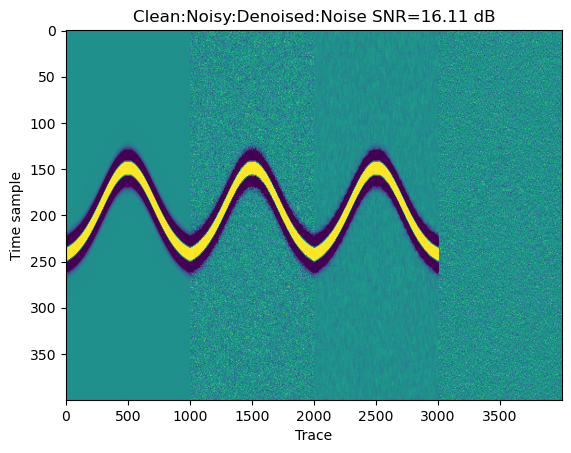

In [9]:
Xout = autoencoder.predict(Xnoisy)

# reconstruct data
denoised=patch2d_inv(Xout,n1,n2,l1=16,l2=16,s1=8,s2=8);

plt.imshow(np.concatenate([data,noisy,denoised,noisy-denoised],axis=1),clim=[-0.2,0.2],aspect='auto');
plt.xlabel('Trace');plt.ylabel('Time sample');plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised)))
plt.show();